<a href="https://colab.research.google.com/github/Karsten-Yan/ky_facs_ai/blob/master/facs_ai_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fcsparser
!pip install scikit-plot
!apt install subversion

import fcsparser
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy import stats
from sklearn.metrics import classification_report
from sklearn.mixture import GaussianMixture
from xgboost import XGBClassifier
import scikitplot as skplt
import matplotlib as mpl

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from umap import UMAP

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# some general parameters for plots
sns.set(style="white", palette="pastel", rc={"lines.linewidth": 2.5})
mpl.rcParams['axes.linewidth'] = 2.5
mpl.rcParams['axes.edgecolor'] = "grey"
mpl.rcParams['figure.edgecolor'] = "grey"
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['legend.edgecolor'] = "grey"
mpl.rcParams['legend.shadow'] = False
mpl.rcParams["legend.framealpha"] = 1
mpl.rcParams['font.weight'] = "bold"
mpl.rcParams['axes.labelweight'] = "bold"
mpl.rcParams['axes.titleweight'] = "bold"

# Data Import

In [ ]:
# import data from github via svn
!svn checkout https://github.com/Karsten-Yan/ky_facs_ai/trunk/data/shedding/export

Checked out revision 23.


In [ ]:
path = "/content/export"

In [ ]:
genotype = ["WT","KO","KO","WT","WT","KO","WT","KO","WT"]
gt_dict = {idx:elm for idx,elm in enumerate(genotype)}

In [ ]:
anti =["CD8","CD62L","CD3","IL6Ra","TNFa","unused","CD4","PacO"]
antibodies = ["pop","stim","mousenr","genotype","FSC_A","FSC_H","FSC_W","SSC_A","SSC_H","SSC_W"] + anti + ["time"]

In [ ]:
#function for reading in multiple facs files
def read_fcs_data(path_sub, gt_dict, antibodies):
    
    df = pd.DataFrame()
    #loop through every file
    for elm in os.listdir(path_sub):
        # only take fcs files      
        if elm.endswith(".fcs"):
          temp_df = pd.DataFrame()
          file = os.path.join(path_sub, elm)

          # parse facs data with fcs parser
          meta, data = fcsparser.parse(file, meta_data_only=False, reformat_meta=True)
          # split file name into components
          elm_split = elm.split("_")
          # split first component again to get population and stimulation info
          # append them to the whole data frame
          split_first = elm_split[0].split(" ")
          temp_df["pop"] = [split_first[-1]]*len(data)
          temp_df["stim"] = [split_first[1]]*len(data)

          # get mouse nr from file name element 2
          int_list = list(elm_split[2])
          gt = int(int_list[2])
          temp_df["mousenr"] = [gt]*len(data)
          # get genotype from mouse nr and genotype dict
          temp_df["genotype"]=[gt_dict[gt-1]]*len(data)

          #concatenate fcs data with prepared meta data
          temp_df = pd.concat([temp_df, data],axis=1)
          
          #concatenate every temp_df prepared by every step of the loop with root df
          df = pd.concat([df, temp_df],axis=0)
    
    # change some cols to categorical to save memory
    df["genotype"] = df["genotype"].astype("category")
    df["pop"] = df["pop"].astype("category")
    df["mousenr"] = df["mousenr"].astype("category")

    # rename columns
    df.columns = antibodies
    df.reset_index(inplace=True)

    # drop unimportant columns
    df.drop("time",inplace=True,axis=1)
    df.drop("index",inplace=True,axis=1)
    df.drop("unused",inplace=True,axis=1)
    df.drop("PacO",inplace=True,axis=1)   
    return df
    

In [ ]:
df = read_fcs_data(path, gt_dict, antibodies)

# Gating and EDA

In [ ]:
numeric_features = list(df.columns[df.dtypes ==  "float32"])
gating_features = ["CD4","CD8"]

In [ ]:
# outlier removal based on z score

z = np.abs(stats.zscore(df[numeric_features]))
dfo = df[(z < 11).all(axis=1)].copy()

In [ ]:
seed=42

In [ ]:
gating = GaussianMixture(3,random_state=seed,covariance_type="full",max_iter=1000,tol = 10)
dfo["label_unmapped"] = gating.fit_predict(dfo[gating_features])

In [ ]:
def facs_plot( stim,pop,mousenr,x,y,c=None,df=dfo):
    fig, ax = plt.subplots(1,1,figsize=(8,8))
    temp_df = df[(df["mousenr"]==mousenr)&(df["pop"]==pop)&(df["stim"]==stim)].sample(frac=0.01)
    ax = sns.scatterplot(data=temp_df, x=x,y=y,hue=c)
    ax.set_xscale("symlog",linthreshx=100,linscalex=0.2)
    ax.set_yscale("symlog",linthreshy=100,linscaley=0.2)
    ax.set_xlim(-1000,300000)
    ax.set_ylim(-1000,300000)
    
    return ax

In [ ]:
xtoggle = widgets.ToggleButtons(options=anti[:5]+[anti[6]], description="Y Axis",value="CD4")
ytoggle = widgets.ToggleButtons(options=anti[:5]+[anti[6]], description="X Axis",value="CD8")
poptoggle = widgets.ToggleButtons(options=list(df["pop"].unique()),description="pop",value="Without")
stimtoggle = widgets.ToggleButtons(options=list(df["stim"].unique()),description="stim",value="Unstimulated")
labeltoggle = widgets.ToggleButtons(options=["label","label_unmapped"],description="hue",value="label_unmapped")

mousenr = widgets.BoundedIntText(min=1,max=np.max(df.mousenr.unique().as_ordered()), description = "mousenr")

out = widgets.interactive_output(facs_plot, {"mousenr":mousenr, "x":xtoggle, "y":ytoggle,"pop":poptoggle,"stim":stimtoggle,"c":labeltoggle})
display(mousenr,xtoggle,ytoggle,poptoggle,stimtoggle,labeltoggle,out)

BoundedIntText(value=1, description='mousenr', max=7, min=1)

ToggleButtons(description='Y Axis', index=5, options=('CD8', 'CD62L', 'CD3', 'IL6Ra', 'TNFa', 'CD4'), value='C…

ToggleButtons(description='X Axis', options=('CD8', 'CD62L', 'CD3', 'IL6Ra', 'TNFa', 'CD4'), value='CD8')

ToggleButtons(description='pop', index=2, options=('GI', 'GW', 'Without'), value='Without')

ToggleButtons(description='stim', index=1, options=('stimulated', 'Unstimulated'), value='Unstimulated')

ToggleButtons(description='hue', index=1, options=('label', 'label_unmapped'), value='label_unmapped')

Output()

In [ ]:
map_dict={0:"rest",2:"CD4TCells",1:"CD8TCells"}
dfo["label"]=dfo["label_unmapped"].map(map_dict)

In [ ]:
dfo["label2"] = dfo["pop"].astype("str")+"_"+dfo["stim"].astype("str")+"_"+dfo["genotype"].astype("str")
dfo["label2"] = dfo["label2"].astype("category")

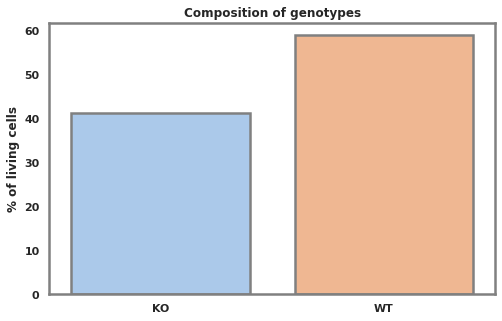

In [ ]:
plt.figure(figsize=(8,5))
geno_data = dfo["genotype"].value_counts()
geno_data = (geno_data/geno_data.sum())*100
geno_data = geno_data.reset_index().sort_values("index")
sns.barplot(y = geno_data["genotype"],x=geno_data["index"], edgecolor="grey",linewidth=2.5)
plt.title("Composition of genotypes")
plt.ylabel("% of living cells")
plt.xlabel("");

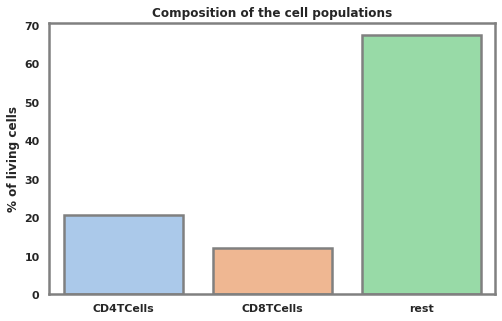

In [ ]:
plt.figure(figsize=(8,5))
pop_data = dfo["label"].value_counts()
pop_data = (pop_data/pop_data.sum())*100
pop_data = pop_data.reset_index().sort_values("index")
ax1 = sns.barplot(y = pop_data["label"],x=pop_data["index"], edgecolor="grey",linewidth=2.5)
plt.title("Composition of the cell populations")
plt.ylabel("% of living cells")
plt.xlabel("");

# DR analysis

In [ ]:
df_unsup = pd.concat([dfo[(dfo["genotype"]=="WT")&(dfo["stim"] == "stimulated")&(dfo["pop"]=="Without")].sample(12500),
                      dfo[(dfo["genotype"]=="KO")&(dfo["stim"] == "stimulated")&(dfo["pop"]=="Without")].sample(12500)], axis=0)
df_unsup_unstim = pd.concat([dfo[(dfo["genotype"]=="WT")&(dfo["stim"] == "Unstimulated")&(dfo["pop"]=="Without")].sample(12500),
                      dfo[(dfo["genotype"]=="KO")&(dfo["stim"] == "Unstimulated")&(dfo["pop"]=="Without")].sample(12500)], axis=0)

In [ ]:
dr_features = set(numeric_features).intersection(set(anti))

In [ ]:
def drr_plot(df,name,hue):
    fig,ax = plt.subplots(1,3,figsize=(20,7))
    sns.scatterplot(x=name+"_dim_2", y=name+"_dim_1", data = df,hue=hue, 
                    ax=ax[0], hue_norm=(0,1000), palette="viridis")
    sns.scatterplot(x=name+"_dim_2", y=name+"_dim_1", data = df[df["genotype"]=="KO"],hue=hue, 
                    ax=ax[1], hue_norm=(0,1000), palette="viridis")
    sns.scatterplot(x=name+"_dim_2", y=name+"_dim_1", data = df[df["genotype"]=="WT"],hue=hue, 
                    ax=ax[2], hue_norm=(0,1000), palette="viridis")
    for i in range(3):
    
      ax[i].set_xlabel("")
      ax[i].set_ylabel("")
      ax[i].set_xticks([])
      ax[i].set_yticks([])
      ax[i].get_legend().remove()
    ax[0].set_title("Both Genotypes")
    ax[1].set_title("Knockout")
    ax[2].set_title("Wildtype")
    plt.suptitle(name + " Analysis "+hue)

## UMAP

In [ ]:
umap = UMAP(n_neighbors=40)
umap_dims = umap.fit_transform(df_unsup[dr_features])
umap_df = pd.DataFrame(umap_dims)
umap_df.columns = ["umap_dim_1","umap_dim_2"]
umap_df = pd.concat([umap_df, df_unsup.reset_index()],axis=1)




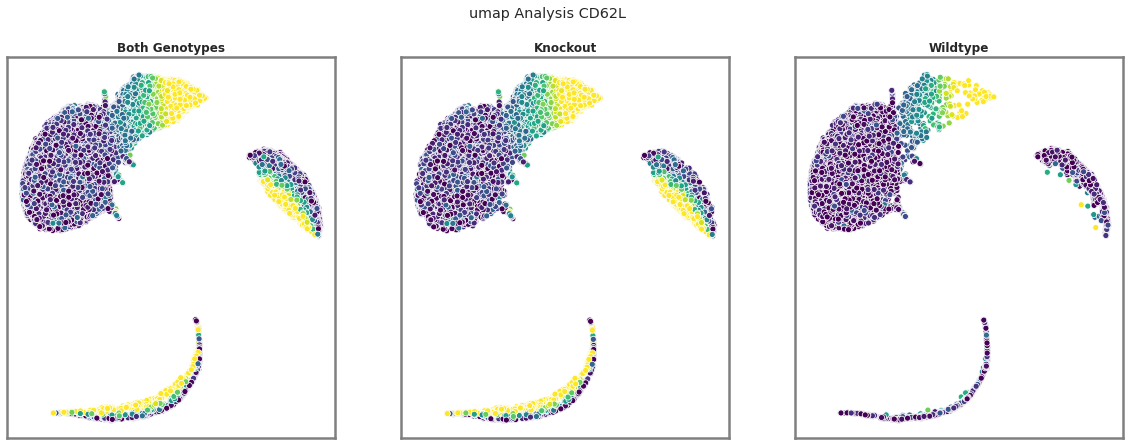

In [ ]:
drr_plot(umap_df,"umap","CD62L")

[Bokeh Visualisation (Heroku)](https://umap-bokeh.herokuapp.com/)

# predictive modelling

In [ ]:
def pop_model(df,gt,pop,x_list, y_label, model, top=3):
    konr = df[df["genotype"]==gt[0]]["mousenr"].unique()
    wtnr = df[df["genotype"]==gt[1]]["mousenr"].unique()
    
    df_train = df[df["mousenr"].isin(konr[:-1])|df["mousenr"].isin(wtnr[:-1])]
    df_val = df[df["mousenr"].isin(konr[-1:])|df["mousenr"].isin(wtnr[-1:])]
  
    df_pop_train = df_train[df_train["label"] == pop]
    df_pop_val = df_val[df_val["label"] == pop]
    
    X_train = df_pop_train[x_list]
    y_train = df_pop_train[y_label]
    X_val = df_pop_val[x_list]
    y_val = df_pop_val[y_label]
    
    model.fit(X_train, y_train)

    classes = model.classes_
    labels = ["\n".join(elm.split("_")) for elm in classes]
    
    y_pred = model.predict(X_val)

    fig, axs = plt.subplots(1,2,figsize=(10,5))
    
    skplt.metrics.plot_confusion_matrix(y_val, y_pred, text_fontsize=10, normalize = True, ax = axs[0])
    axs[0].set_yticklabels(labels=labels)
    axs[0].set_xticklabels(labels=labels)
    axs[0].images[-1].colorbar.remove()
    
    skplt.estimators.plot_feature_importances(model, feature_names=x_list,max_num_features=20, ax = axs[1])
    fig.set_edgecolor("grey")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show();
    
    fimp = sorted([(elm,numeric_features[idx]) for idx,elm in enumerate(model.feature_importances_)],reverse=True)
    
    fig, axs = plt.subplots(1,top,figsize=(9,3))
    for i in range(top):
        sns.barplot(x = df_pop_train.genotype.astype("object"), y = df_pop_train[fimp[i][1]], ax = axs[i], hue_order = ["WT","KO"], edgecolor="grey",linewidth=2.5)
    plt.tight_layout()
    plt.suptitle("Top "+str(top)+" important features",fontweight="bold")
    plt.subplots_adjust(top=0.9,hspace = 0)
    plt.show()
    
    print("-"*20+"Classification Report"+"-"*20)
    print(classification_report(y_val, y_pred))

## CD8

### CD8 without

In [ ]:
df_sup_wo = dfo[(dfo["stim"] == "stimulated")&(dfo["pop"]=="Without")]

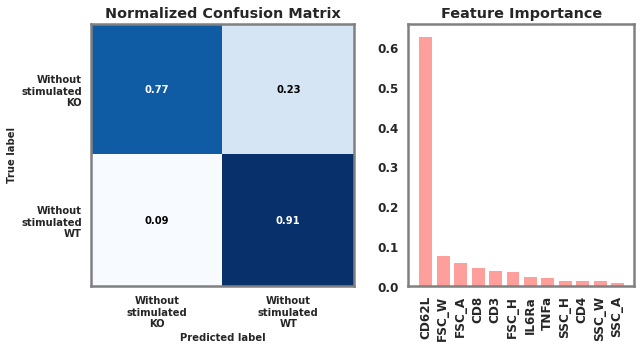

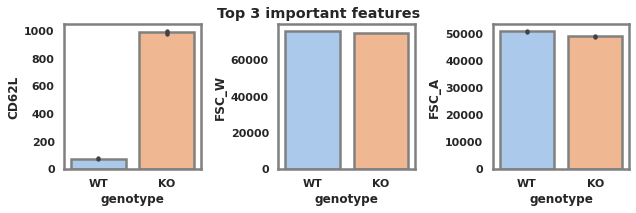

--------------------Classification Report--------------------
                       precision    recall  f1-score   support

Without_stimulated_KO       0.90      0.77      0.83     13095
Without_stimulated_WT       0.79      0.91      0.85     12460

             accuracy                           0.84     25555
            macro avg       0.85      0.84      0.84     25555
         weighted avg       0.85      0.84      0.84     25555



In [ ]:
xgb_clf_cd8_wo = XGBClassifier(n_jobs = -1,random_state=42)
pop_model(df_sup_wo,["WT","KO"],"CD8TCells",numeric_features, "label2", xgb_clf_cd8_wo,3)

### CD8 gw

In [ ]:
df_sup_gw = dfo[(dfo["stim"] == "stimulated")&(dfo["pop"]=="GW")]

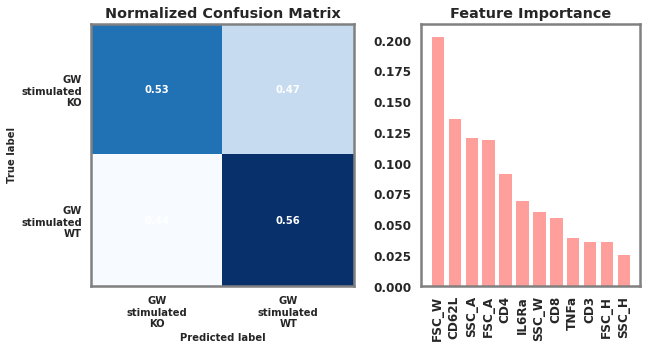

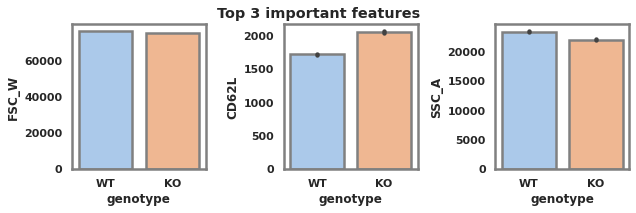

--------------------Classification Report--------------------
                  precision    recall  f1-score   support

GW_stimulated_KO       0.55      0.53      0.54     12658
GW_stimulated_WT       0.54      0.56      0.55     12452

        accuracy                           0.54     25110
       macro avg       0.54      0.54      0.54     25110
    weighted avg       0.54      0.54      0.54     25110



In [ ]:
xgb_clf_cd8_gw = XGBClassifier(n_jobs = -1,random_state=42)
pop_model(df_sup_gw,["WT","KO"],"CD8TCells",numeric_features, "label2", xgb_clf_cd8_gw,3)

## CD4

### CD4 without

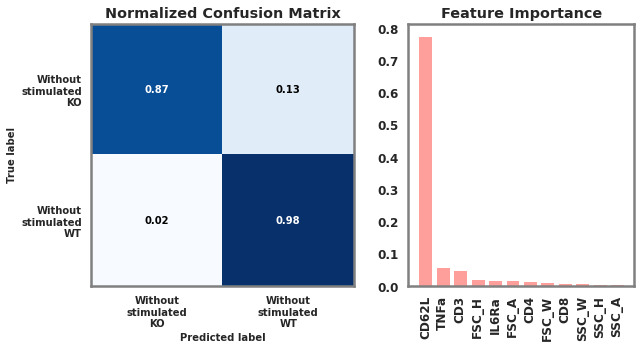

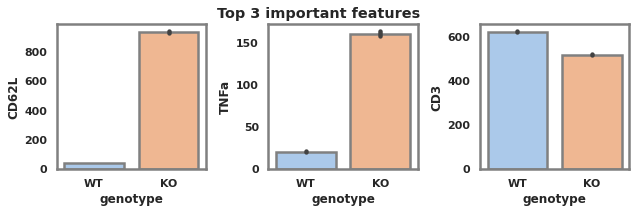

--------------------Classification Report--------------------
                       precision    recall  f1-score   support

Without_stimulated_KO       0.97      0.87      0.92     21009
Without_stimulated_WT       0.89      0.98      0.93     22326

             accuracy                           0.93     43335
            macro avg       0.93      0.92      0.93     43335
         weighted avg       0.93      0.93      0.93     43335



In [ ]:
xgb_clf_cd4_wo = XGBClassifier(n_jobs = -1,random_state=42)
pop_model(df_sup_wo,["WT","KO"],"CD4TCells",numeric_features, "label2", xgb_clf_cd4_wo,3)

### CD4 gw

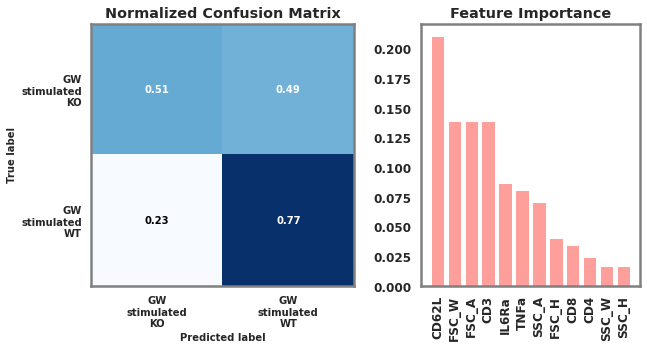

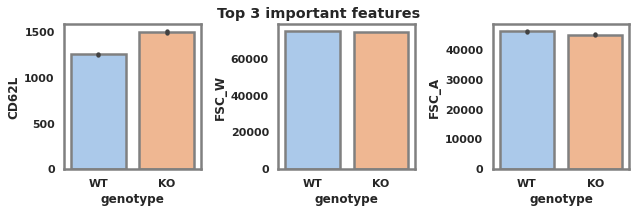

--------------------Classification Report--------------------
                  precision    recall  f1-score   support

GW_stimulated_KO       0.71      0.51      0.60     23694
GW_stimulated_WT       0.58      0.77      0.66     20729

        accuracy                           0.63     44423
       macro avg       0.65      0.64      0.63     44423
    weighted avg       0.65      0.63      0.62     44423



In [ ]:
xgb_clf_cd4_gw = XGBClassifier(n_jobs = -1,random_state=42)
pop_model(df_sup_gw,["WT","KO"],"CD4TCells",numeric_features, "label2", xgb_clf_cd4_gw,3)

## rest

### rest without

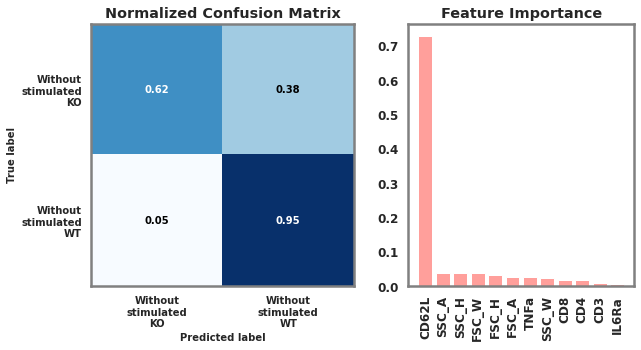

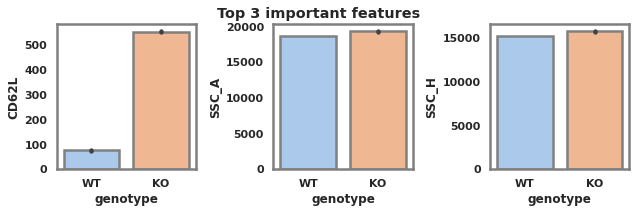

--------------------Classification Report--------------------
                       precision    recall  f1-score   support

Without_stimulated_KO       0.92      0.62      0.74     70586
Without_stimulated_WT       0.73      0.95      0.83     76435

             accuracy                           0.79    147021
            macro avg       0.82      0.79      0.78    147021
         weighted avg       0.82      0.79      0.79    147021



In [ ]:
xgb_clf_rest_wo = XGBClassifier(n_jobs = -1,random_state=42)
pop_model(df_sup_wo,["WT","KO"],"rest",numeric_features, "label2", xgb_clf_rest_wo,3)

### rest gw

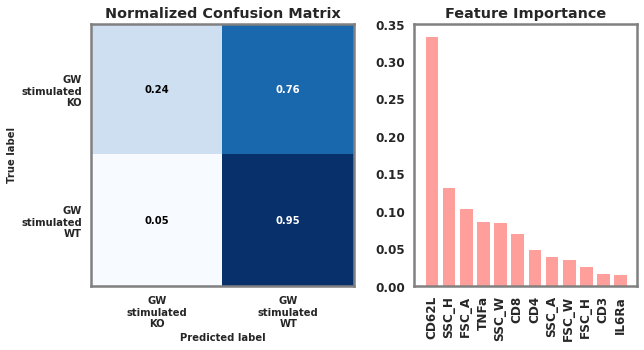

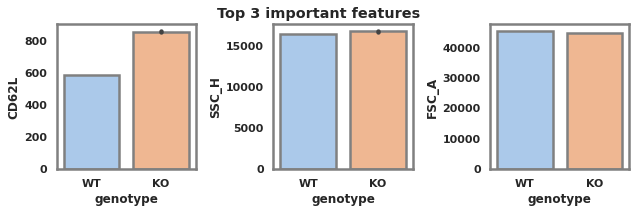

--------------------Classification Report--------------------
                  precision    recall  f1-score   support

GW_stimulated_KO       0.80      0.24      0.37     72015
GW_stimulated_WT       0.58      0.95      0.72     79302

        accuracy                           0.61    151317
       macro avg       0.69      0.59      0.54    151317
    weighted avg       0.68      0.61      0.55    151317



In [ ]:
xgb_clf_rest_gw = XGBClassifier(n_jobs = -1,random_state=42)
pop_model(df_sup_gw,["WT","KO"],"rest",numeric_features, "label2", xgb_clf_rest_gw,3)